I want to try to turn the date data into some more cylidrical data and see if it improves prediction, but it doesn't

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
"""
This cell gets the data ready to get passed into a pipeline
"""
#Import the Data set
df = pd.read_csv("data\\Traffic.csv")
df.dropna()

#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

#There is only 31 days in the data, so we project it onto this circle
X["day_of_the_month_sin"] = np.sin(2 * np.pi * X["Date"] / 31)
X["day_of_the_month_cos"] = np.cos(2 * np.pi * X["Date"] / 31)
X = X.drop(columns="Date")

#For the Time, I want to module it all as a cylce
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]

X["Time_sin"] = np.sin(2 * np.pi * X["Time"] / 1425)
X["Time_cos"] = np.cos(2 * np.pi * X["Time"] / 1425)
X = X.drop(columns=['hour', 'minute', 'Time'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

#I want to round X to try to fix some floating point errors, and it worked
X = np.round(X, decimals=5)

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [10]:
# Define features
numeric_features = ["day_of_the_month_cos", "day_of_the_month_sin", 'Time_sin', 'Time_cos', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
categorical_features = ['Day of the week']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scalar", StandardScaler()) #We're gonna normalize the numeric data 
])

#This is for the catergorical features
categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")) #Shouldn't have to worry about unknowns 
])

#Put it into one preprosser
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define the full pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

Making the dates and such clydrical makes the outputs slightly worst sadly

In [11]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search.best_params_)

y_pred_best = grid_search.best_estimator_.predict(X_test)
print(f"This is the accuracy score: {accuracy_score(y_test, y_pred_best):.4f}")

Best Parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
This is the accuracy score: 0.9681


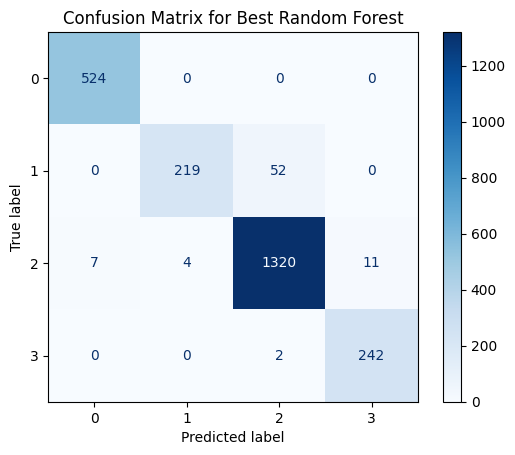

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap="Blues")  
plt.title("Confusion Matrix for Best Random Forest")
plt.show()